# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [129]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../traffic-signs-data/train.p'
validation_file='../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [130]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = len(train['labels'])

# TODO: Number of validation examples
n_valid = len(valid['labels'])

# TODO: Number of testing examples.
n_test = len(test['labels'])

# TODO: What's the shape of an traffic sign image?
image_shape = train['features'][0].shape

# TODO: How many unique classes/labels there are in the dataset.
labels = [ l for l in train['labels'] ] + [l for l in valid['labels']] + [l for l in test['labels']]
n_classes = len(set(labels))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Step 1: Visualizing each class of signs to see what kind of data we have.
Using numpy and matlib, lets take a look at the data.

In [131]:
import random
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

from augmenter import DataAugmenter
augmenter = DataAugmenter()

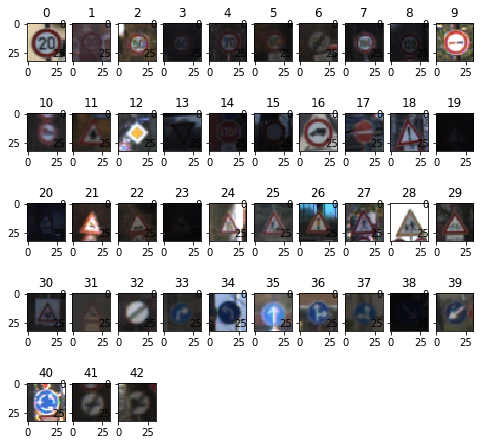

In [132]:
one_img_each_class = [None]*43
num_saved = 0
X = np.concatenate((X_train, X_valid, X_test), axis=0)
y = np.concatenate((y_train, y_valid, y_test), axis=0)

for img, label in zip(X, y):
    if one_img_each_class[label] is None:
        one_img_each_class[label] = img
        num_saved += 1
    if num_saved == 43:
        break
augmenter.show_multiple_image_changes(10, 5, one_img_each_class, [i for i in range(0, 43)])

Looking at the data, I can see we have 43 classes of small color images. Many are very are low quality and difficult to see. Histogram equalization during preprocessing may help with this issue. 

### Step 2: Image Distrirbutions

In [133]:
def plot_labels(y_labels, title):
    label_totals = {}
    for y in y_labels:
        try:
            label_totals[y] += 1
        except:
            label_totals[y] = 1

    print("Number of Images:", len(y_labels))
    x = np.arange(n_classes)
    plt.subplots(figsize=(16,5))
    plt.title(title)
    plt.bar(x, height=[label for label in label_totals.values()], width=0.8, align='edge')
    plt.xticks(x+.5, [str(label) for label in label_totals])
    plt.ylabel('Number of Images')
    plt.xlabel('Class')
    plt.show()

Number of Images: 34799


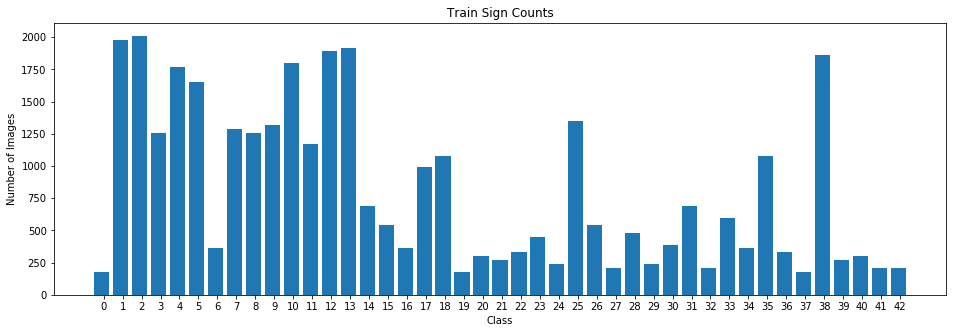

In [134]:
plot_labels(y_train, 'Train Sign Counts')

Number of Images: 4410


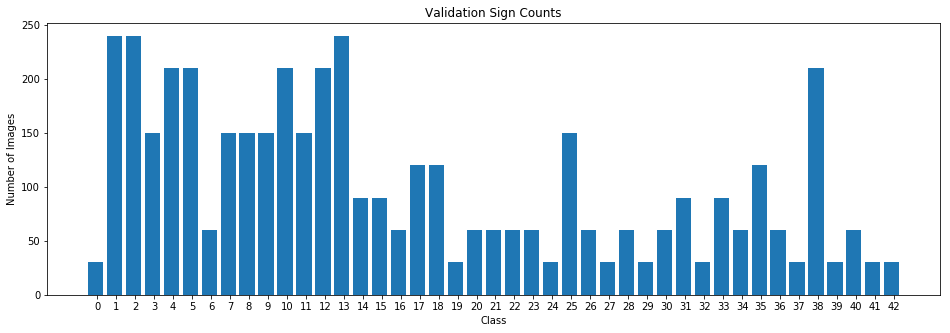

In [135]:
plot_labels(y_valid, 'Validation Sign Counts')

Number of Images: 12630


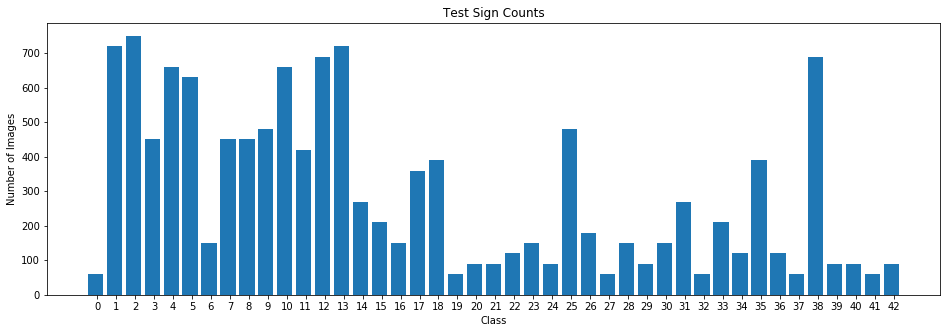

In [136]:
plot_labels(y_test, 'Test Sign Counts')

I can see the data is very uneven with certain classes appearing far more than others. Data augmentation should help with that. I also notice the test dataset is larger than the others.

## Augment Data
I'll augment the data to create more data points for the classes with fewer data points. So that I will be able to correctly identify those classes I have a smaller sample size for. Below are the methods I created to augment the data.

In [137]:
#sample image to show augmentation methods
img = X_train[100].copy()

### Brightness

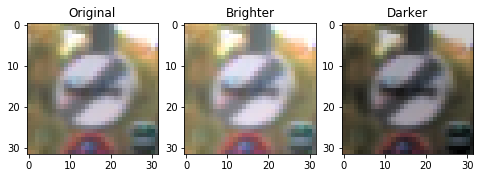

In [138]:
brighter_image = augmenter.brightness(img, value=20, increase=True)
darker_image = augmenter.brightness(img, value=50, increase=False)
#augmenter.show_image_changes(img, new_image, effect='Brightness')
augmenter.show_multiple_image_changes(3, 1, [img, brighter_image, darker_image], ['Original', 'Brighter', 'Darker'])

### Blur

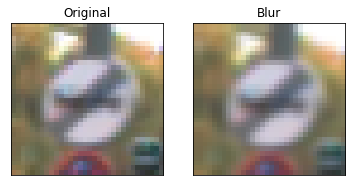

In [139]:
new_image = augmenter.blur(img, box_size=(2,2))
augmenter.show_image_changes(img, new_image, effect='Blur')

### Rotate

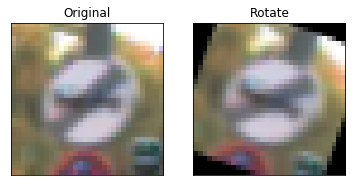

In [140]:
new_image = augmenter.rotation(img, degrees=-20)
augmenter.show_image_changes(img, new_image, effect='Rotate')

### Translation

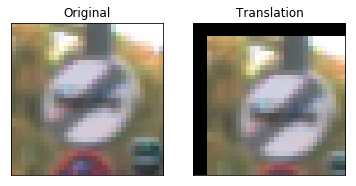

In [141]:
new_image = augmenter.translation(img, x=3, y=3) #1-5 is the range I would do here
augmenter.show_image_changes(img, new_image, effect='Translation')

### Skew

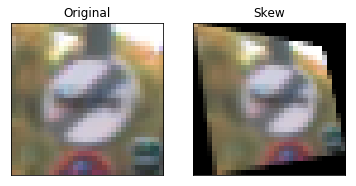

In [142]:
new_image = augmenter.skew(img, np.float32([[0,0],[32,0],[0,32],[32,32]]), 
                          np.float32([[0, 0], [27, 5], [5, 32],[32, 27]]))
augmenter.show_image_changes(img, new_image, effect='Skew')

### Flip

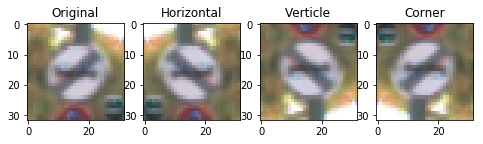

In [143]:
# while flip was written, I decided to hold off on using it due to the fact that it can change the meaning of a sign
horizontal_img = augmenter.flip(img,  direction=augmenter.HORIZONTAL_FLIP)
verticle_img = augmenter.flip(img,  direction=augmenter.VERTICAL_FLIP)
corner_flip = augmenter.flip(img, direction=augmenter.CORNER_FLIP)
augmenter.show_multiple_image_changes(4, 1, [img, horizontal_img, verticle_img, corner_flip], 
                                      ['Original', 'Horizontal', 'Verticle', 'Corner'])

In [145]:
import random
def sort_img_by_label(images, labels):
    sorted_images = [[] for _ in range(43)]
    for img, label in zip(images, labels):
        sorted_images[label].append(img)
    return sorted_images

def augment_images(sorted_images, min_num):
    new_images = []
    new_labels = []
    img_corners = np.float32([[0,0],[32,0],[0,32],[32,32]])
    for label, images in enumerate(list(sorted_images)):
        start = len(images)
        if start >= min_num:
            start = min_num-100
        for i in range(start, min_num):
            img = random.choice(images)
            increase_brightness = random.choice([True, False])
            bright_value = random.randint(0, 50)
            blur_value = (random.randint(1,3), random.randint(1,3))
            rotation_value = random.randint(-20,20)
            translation_value = (random.randint(-3,3), random.randint(-3,3))
            skew_top_value = random.randint(25, 32)
            skew_bottom_value = random.randint(0, 5)        
            skew_value = (img_corners, 
                          np.float32([[0, 0], [skew_top_value, skew_bottom_value], 
                                      [skew_bottom_value, 32],[32, skew_top_value]]))
            
            new_img = augmenter.brightness(img, value=bright_value, increase=increase_brightness)
            new_img = augmenter.skew(img, skew_value[0], skew_value[1])
            new_img = augmenter.blur(new_img, box_size=blur_value)
            new_img = augmenter.rotation(new_img, degrees=rotation_value)
            new_img = augmenter.translation(new_img, x=translation_value[0], y=translation_value[1])
            
            new_images.append(new_img)
            new_labels.append(label)
            sorted_images[label].append(new_img)
            
    return new_images, new_labels



Before Augmenting the data, I combine the training and validation data, and augment it. Then, I remove 20% of my data for validation leaving the rest for training.

Before: X= 39209 y= 39209
After: X= 56410 y= 56410
Number of Images: 56410


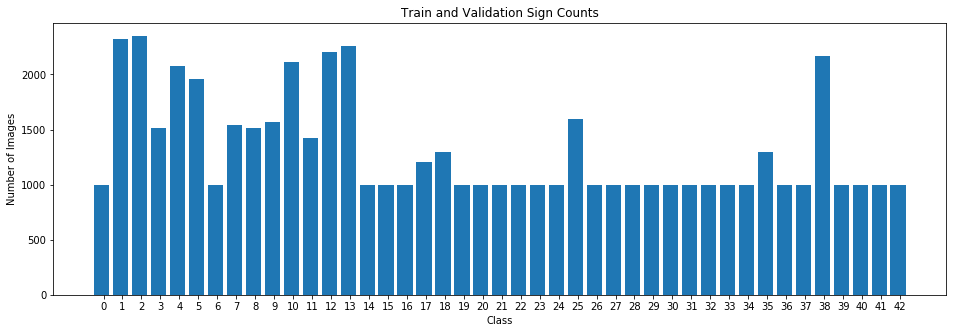

In [146]:
X  = np.concatenate((X_train, X_valid), axis=0)
y = np.concatenate((y_train, y_valid), axis=0)
print("Before: X=", len(X), "y=", len(y))
sorted_images = sort_img_by_label(X, y)
X_new, y_new = augment_images(sorted_images, 1000)
X  = np.concatenate((X, X_new), axis=0)
y = np.concatenate((y, y_new), axis=0)
print("After: X=", len(X), "y=", len(y))
plot_labels(y, 'Train and Validation Sign Counts')

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

X_train= 45128 y_train= 45128
Number of Images: 45128


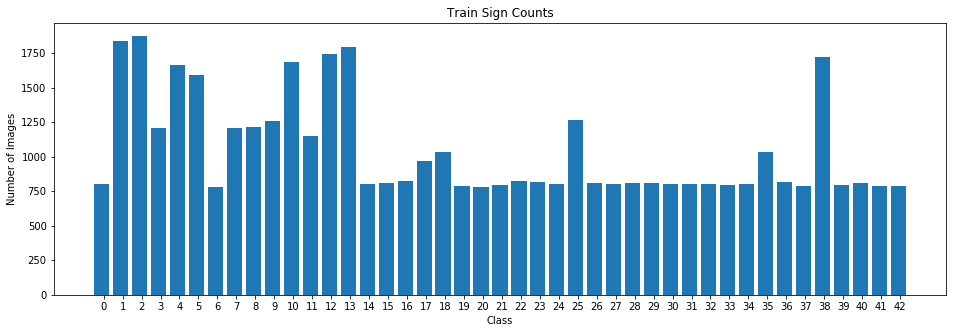

In [148]:
print("X_train=", len(X_train), "y_train=", len(y_train))
plot_labels(y_train, 'Train Sign Counts')

X_valid= 11282 y_valid= 11282
Number of Images: 11282


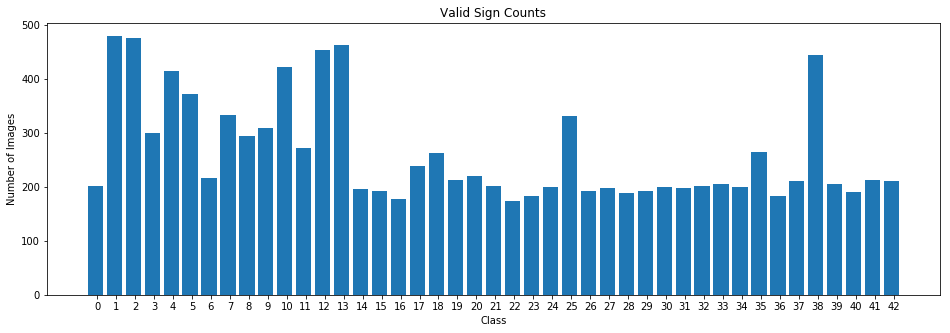

In [149]:
print("X_valid=", len(X_valid), "y_valid=", len(y_valid))
plot_labels(y_valid, 'Valid Sign Counts')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

For preprocessing I do the following steps:

- Resize the Image: Resizing the image to the standard 32x32 format

- Histogram equalization: to better handle those images that are lower quality (darker/unclear/blurred) and harder to discern 

- Greyscale Conversion: converting to greyscale speeds up the learning process as the color does not add much to these images and is not necessary for identification. Note I add a color channel of 1 after converting

- Normalizing: I normalize the data so that it is possible to process

In [150]:
from preprocessor import Preprocessor
def normalize_data(X):
    return X/255.0 - 0.5

def preprocess_images(images):
    processor = Preprocessor()
    processed_images = []
    
    for img in images:
        img = processor.resize(img, size=(32, 32)) #resize with default image size (32, 32)
        img = processor.histogram_equalization(img)
        img = processor.greyscale(img)
        img = img[:, :, np.newaxis]

        processed_images.append(img)
    
    return normalize_data(np.array(processed_images))

X_train = preprocess_images(X_train)

print('Train:', X_train.shape)
X_valid = preprocess_images(X_valid)
print('Validate', X_valid.shape)
X_test = preprocess_images(X_test)
print('Test', X_test.shape)

Train: (45128, 32, 32, 1)
Validate (11282, 32, 32, 1)
Test (12630, 32, 32, 1)


### Model Architecture

My final model is a combination of theLeNet Architure from the lab and ideas from this paper: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf.

I began with the Lenet archetecture and began experimenting from there; simply trial and error until I found a model that worked. 

Layer | Input | Output
:-------: | :-------: | :-------:
Convolutional Layer 1 | 32x32x1 | 28x28x6
ReLu Activation | | 
Max Pooling | 28x28x6 | 14x14x6
Convolutional Layer 2 | 14x14x6 | 10x10x16
ReLu Activation | |
Max Pooling | 10x10x16 | 5x5x16
Convolutional Layer 3 | 5x5x16 | 1x1x400
Flatten | 1x1x400 | 400
Fully Connected Layer 1 | 400 | 120
ReLu Activation | |
Dropout | |
Fully Connected Layer 2 | 120 | 84
ReLu Activation | |
Dropout | |
Fully Connected Layer 3 | 84 |43
ReLu Activation | |
Dropout | |


Based off the LeNet Architecture with modifications:
- Three convolutional layers to improve accuracy.
- Dropout added to prevent overfitting 

In [35]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

# Convolution 1
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Convolution 2
    # SOLUTION: Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
 
 # Convolution 3   
     # SOLUTION: Layer 3: Convolutional. Input = 5x5x16 Output = 1x1x400.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b

    # SOLUTION: Flatten. Input = 1x1x400. Output = 400.
    fc0   = flatten(conv3)
    #fc0_2 = flatten(conv2)
    #fc0 = tf.concat_v2([fc0, fc0_2], 1)
 
 # Fully Connected Layers
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
     # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
     # dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [525]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 100

In [526]:
#x is a placeholder for a batch of input images. 
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
# y is a placeholder for a batch of output labels
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [527]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [528]:
#Training pipeline
rate = 0.0009

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [529]:
# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [530]:
from sklearn.utils import shuffle
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        #Before each epoch, shuffle the training set.
        X_train, y_train = shuffle(X_train, y_train)
        
        # Run the training data through the training pipeline to train the model.
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})

        # After each epoch, measure the loss and accuracy of the validation set.
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
      
    # Save the model after training.
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.708

EPOCH 2 ...
Validation Accuracy = 0.858

EPOCH 3 ...
Validation Accuracy = 0.882

EPOCH 4 ...
Validation Accuracy = 0.919

EPOCH 5 ...
Validation Accuracy = 0.923

EPOCH 6 ...
Validation Accuracy = 0.933

EPOCH 7 ...
Validation Accuracy = 0.936

EPOCH 8 ...
Validation Accuracy = 0.947

EPOCH 9 ...
Validation Accuracy = 0.938

EPOCH 10 ...
Validation Accuracy = 0.945

EPOCH 11 ...
Validation Accuracy = 0.949

EPOCH 12 ...
Validation Accuracy = 0.943

EPOCH 13 ...
Validation Accuracy = 0.950

EPOCH 14 ...
Validation Accuracy = 0.950

EPOCH 15 ...
Validation Accuracy = 0.944

EPOCH 16 ...
Validation Accuracy = 0.950

EPOCH 17 ...
Validation Accuracy = 0.946

EPOCH 18 ...
Validation Accuracy = 0.951

EPOCH 19 ...
Validation Accuracy = 0.950

EPOCH 20 ...
Validation Accuracy = 0.950

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

#TODO: Take Legits outputted from model
# run it through tf.nn.softmax to get probabilities
# then use tf.nn.top_k to just get the top 5 probabilities

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")